In [1]:
import pandas as pd
import numpy as np
import itertools
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Pre-ferment Models for Leaven Foods (Poolish)

In this notebook, we build models based on real-world data about poolish fermentation. The key measurements include:

* Time to peak and duration at peak:
    * We used stop motion (in combination with acidity when relevent) to capture this.
* Yeast amount as a baker’s percentage:
    * Expressed below in terms of instant dry yeast equivalent.
* Fermentation temperature:
    * Two key assumptions for modeling (which may vary in real-world scenarios):
        * The final dough temperature after mixing is the same as the fermentation temperature.
        * Fermentation occurs at a single, constant temperature.

We collected this data for both our Wild Yeast and All-Purpose products. As a positive control, we included instant dry yeast, for which fermentation characteristics are well-established from other sources. All experiments were done for 1000 grams of dough at 100% hydration. 


In [6]:
# first we import the data and clean it a bit
data = pd.read_csv('../data/preferment-experiments-hydration.csv', index_col=None)
data['yeast_amount'] = data['Leven_Inclusion (IDY equivalent)']
data['hour'] = [float(x.replace('hours','').lstrip().rstrip()) for x in data['Time']]
data['temp'] = [float(x.replace(' F','').lstrip().rstrip()) for x in data['Temperature']]
data['hydration'] = data['Hydration']
data_clean = data[['yeast_amount','hour','temp', 'hydration']]
data_clean.head(5)


,yeast_amount,hour,temp,hydration
0,0.05,15.0,72.0,100
1,0.30,6.0,72.0,100
2,0.45,4.0,72.0,100
3,0.25,7.0,72.0,100
4,0.25,4.0,80.0,100


### Look at the data

The first step is to examine the distributions of each variable to better understand how to model them. We'll use [kernel density plots](https://en.wikipedia.org/wiki/Kernel_density_estimation) to visualize the distribution of each variable below.

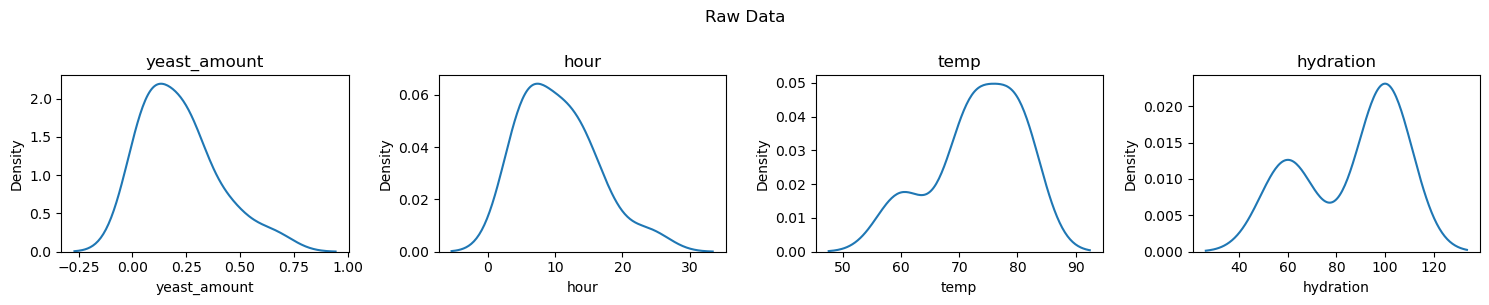

In [7]:
fig, axn = plt.subplots(1, 4, figsize=(15, 3))
for c_, ax in zip(data_clean.columns, axn):
    sns.kdeplot(data_clean[c_], ax=ax)
    ax.set_title(c_)
plt.suptitle('Raw Data', y=1.0)
plt.tight_layout()
plt.show()

It’s clear that some variables are not normally distributed. While we could handle this within the model (e.g., by normalization or more complex techniques), for simplicity, I’ll apply a log transformation. Since these variables appear approximately log-normally distributed, a log transformation should bring them closer to a normal distribution.

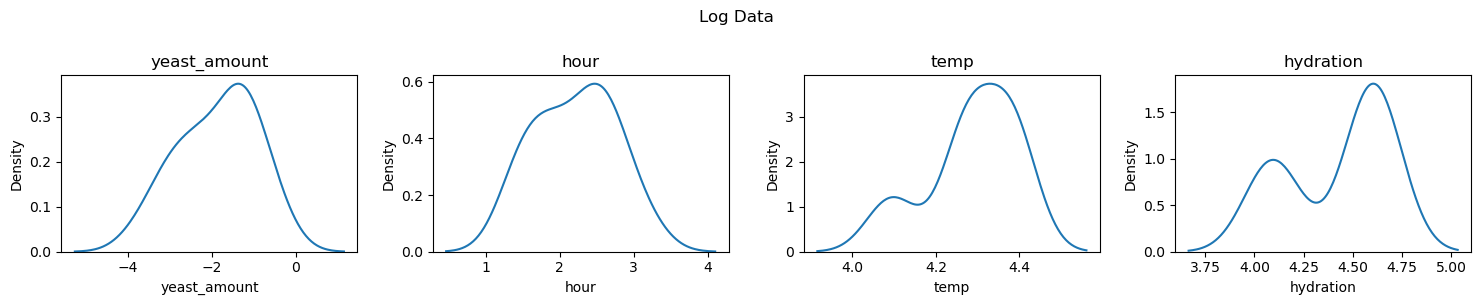

In [8]:

fig, axn = plt.subplots(1, 4, figsize=(15, 3))
for c_, ax in zip(data_clean.columns, axn):
    sns.kdeplot(data_clean[c_].apply(np.log), ax=ax)
    ax.set_title(c_)
plt.suptitle('Log Data', y=1.0)
plt.tight_layout()
plt.show()

Yes, much better. We are ready to model!

## Model and cross-validation


Here we will build a linear model (again keeping things simple). Given by:

$$ \hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \epsilon $$

where:

* $\hat{y}$ = predicted time (in hours)
* $\beta_0$ = intercept (baseline time in hours)
* $\beta_1, \beta_2, \beta_3$ = slopes associated with $x_1$, $x_2$, and $x_3$
* $x_1, x_2, x_3$ = amount of yeast, fermentation temperature, and dough hydration
* $\epsilon$ = model error

Note: Although we are not modeling hydration yet in this notebook, it is included here for completeness as it will be added in future versions.

To evaluate the model, we'll use Leave-One-Out Cross-Validation (LOOCV). In LOOCV, we train the model on all data points except one, predict the excluded point, and repeat this process for each point in the dataset. We will assess model performance by calculating the mean absolute error between the predicted and actual measured fermentation times (in hours).


In [21]:
data_clean_transformed = data_clean.copy().apply(np.log)
X = data_clean_transformed[['yeast_amount','temp','hydration']].values
y = data_clean_transformed[['hour']].values
# get all splits
loo = LeaveOneOut()
loo.get_n_splits(X)
# run train/test
mae_loo = []
yhat = []
ytrue = []
for i, (train_index, test_index) in enumerate(loo.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr_fit = LinearRegression().fit(X_train, y_train)
    y_hat = lr_fit.predict(X_test)
    mae_loo.append(mean_absolute_error(y_test, y_hat))
    yhat.append(y_hat[0][0])
    ytrue.append(y_test[0][0])
print("MAE=%.2f hours, $R^{2}$=%.2f" % (np.exp(mean_absolute_error(ytrue, yhat)), 
                                        r2_score(ytrue, yhat)))


MAE=1.11 hours, $R^{2}$=0.93


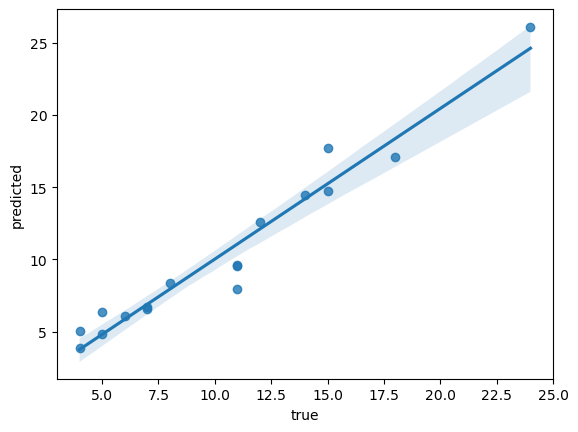

In [22]:
sns.regplot(x='true', y='predicted', 
            data=pd.DataFrame([ytrue, yhat], ['true','predicted']).T.apply(np.exp))
plt.show()


Our current model accuracy is 1.1 hours. We expect this to improve as we add more data and conduct additional experiments.

# Making predictions

Now, we'll predict the number of hours the pre-ferment will take to reach peak fermentation based on the temperature (°F) and the amount of our product(s) added, expressed as a baker’s percentage.

In [49]:
pred_by_product = {}
product_conversion = {'all-purpose':6.5, 'wild-yeast':5.0}
product_abbv = {'all-purpose':'LAP', 'wild-yeast':'LWY'}
# amounts by product to model
ap_amounts = np.hstack([np.arange(0.006, 0.01, 0.001),
                        np.arange(0.01, 0.09 + 0.01, 0.01),
                        np.arange(0.1, 2 + 0.1, 0.1)]) 
wy_amounts = np.hstack([np.arange(0.005, 0.01, 0.001),
                        np.arange(0.01, 0.09 + 0.01, 0.01),
                        np.arange(0.1, 2 + 0.1, 0.1)])
product_amounts = {'all-purpose':ap_amounts, 'wild-yeast':wy_amounts}
# init temps
min_temp = 40
max_temp = 95
step_temp = 1
# init hydration
min_hydration = 45
max_hydration = 100
step_hydration = 1

for product_type, conversion in product_conversion.items():
    print("Building model for %s" % product_type)
    # make model data
    all_temps = np.arange(min_temp, max_temp + step_temp, step_temp) # every temp
    all_hydration = np.arange(min_hydration, max_hydration + step_hydration, step_hydration) # every hydration
    all_amount = product_amounts[product_type] # % amounts 
    all_combos = list(itertools.product(all_amount, all_temps, all_hydration)) # get all combinations of the two
    all_combos = np.array(all_combos)
    print("Number of possible scenarios: %i" % len(all_combos))
    # for conversion
    data_clean_transformed = data_clean.copy()
    data_clean_transformed['yeast_amount'] *= conversion
    data_clean_transformed = data_clean_transformed.apply(np.log)
    X = data_clean_transformed[['yeast_amount','temp','hydration']].values
    y = data_clean_transformed[['hour']].values
    # model
    lr_fit = LinearRegression().fit(X, y)
    # predict all
    all_hours = np.exp(lr_fit.predict(np.log(np.array(all_combos))))
    # make table
    all_predictions = pd.DataFrame(np.hstack([all_combos, all_hours]),
                                   columns=['yeast_amount', 'temp_F', 'hydration', 'time_hour'])
    pred_by_product[product_type] = all_predictions.copy()
# save data
path_ = '../results/'
for name_, res_df in pred_by_product.items():
    res_df.to_csv(path_ + name_ + '-all-hydrations.csv')

Building model for all-purpose
Number of possible scenarios: 103488
Building model for wild-yeast
Number of possible scenarios: 106624


Now that we have generated the prediction tables, they are stored in the results directory for each product. The next step will be to build a simple graphical interface so users can easily search and find the information they need.